<a href="https://colab.research.google.com/github/ewunder32/lab_scraping/blob/main/lab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [ ]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [ ]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [ ]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

With the data in and wrangled, we can now do some analysis:

In [ ]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [ ]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

In [ ]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

In [ ]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.
4. Document all your work as code and markdown blocks in this notebook.

In [ ]:
# First, we need to scrape the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup as soup

# Define the URL and headers
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/sss?query=ski#search=1~gallery~0~0'
raw = requests.get(url, headers=header)

# Parse the HTML content
bsObj = soup(raw.content,'html.parser')
listings = bsObj.find_all(class_="cl-static-search-result")

# Loop through listings and extract data
data = []
for listing in listings:
    try:
        title = listing.find('div', class_='title').get_text().strip()
        price_raw = listing.find('div', class_='price').get_text().strip()
        link = listing.find('a', href=True)['href']
        location = listing.find('div', class_='location').get_text().strip()
        data.append({'title': title, 'price': price_raw, 'link': link, 'location': location})
    except AttributeError:
        # Skip listings that don't have all the required information
        continue

DataFrame Shape: (14, 4)

First 5 rows of the DataFrame:
                                               title  price  \
0                                  Ski Carrier Strap     10   
1          Hawke & Co. Men's 3-in-1 Large Ski Jacket     60   
2                                 K2 120cm ski poles     20   
3  Men's Large Columbia Sportswear 3-in-1 Ski Jac...    125   
4                                2005 Seadoo Jet Ski   3000   

                                                link          location  
0  https://charlottesville.craigslist.org/spo/d/c...   Charlottesville  
1  https://charlottesville.craigslist.org/clo/d/c...   Charlottesville  
2  https://charlottesville.craigslist.org/spo/d/g...  Old Trail Crozet  
3  https://charlottesville.craigslist.org/spo/d/c...   Charlottesville  
4  https://charlottesville.craigslist.org/boa/d/s...       Scottsville  

Price descriptive statistics:
count       14.000000
mean      1013.928571
std       2840.804449
min         10.000000
25%    

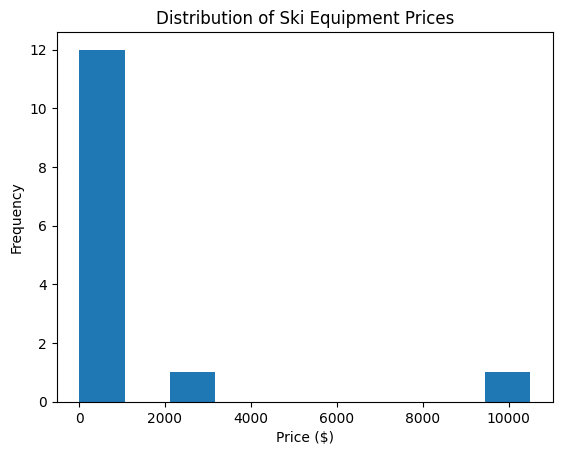


Price descriptive statistics by location:
                 price                                                       \
                 count    mean          std     min     25%     50%     75%   
location                                                                      
Charlottesville   10.0  1104.5  3301.454604    10.0    35.0    55.0   100.0   
Crozet             1.0    50.0          NaN    50.0    50.0    50.0    50.0   
Old Trail Crozet   1.0    20.0          NaN    20.0    20.0    20.0    20.0   
Ruckersville       1.0    80.0          NaN    80.0    80.0    80.0    80.0   
Scottsville        1.0  3000.0          NaN  3000.0  3000.0  3000.0  3000.0   

                           
                      max  
location                   
Charlottesville   10500.0  
Crozet               50.0  
Old Trail Crozet     20.0  
Ruckersville         80.0  
Scottsville        3000.0  


/tmp/ipython-input-690953872.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


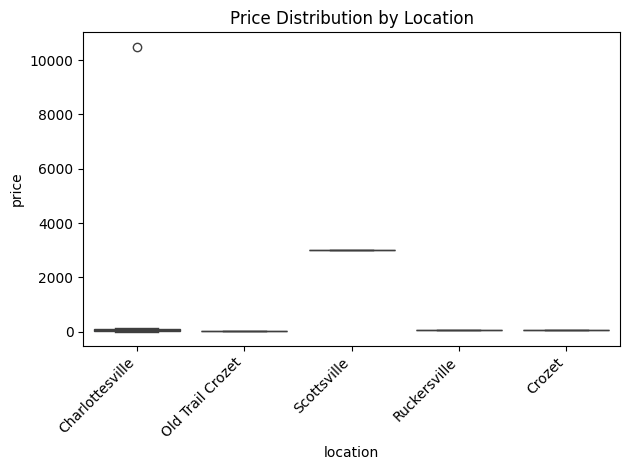


Most common words in listing titles:
[('ski', 5), ('with', 3), ('carrier', 2), ("men's", 2), ('3-in-1', 2), ('large', 2), ('antique', 2), ('wooden', 2), ('condor', 2), ('ice', 2)]


In [ ]:
# Then we will do the data wrangling on Ski Equipment found on Craigslist
df = pd.DataFrame.from_dict(data)

# Clean and convert the 'price' column
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(subset=['price'], inplace=True) # Remove rows with no price

import os
os.makedirs('./src', exist_ok=True) # Create the 'src' directory if it doesn't exist

print("DataFrame Shape:", df.shape)
print("\nFirst 5 rows of the DataFrame:")
print(df.head())

# Save the data
df.to_csv('./src/craigslist_cville_ski.csv', index=False)

# Basic descriptive statistics and plots
print("\nPrice descriptive statistics:")
print(df['price'].describe())
df['price'].hist(grid=False)
plt.title('Distribution of Ski Equipment Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

# Analysis by location (if location data is robust)
if not df['location'].isnull().all():
    print("\nPrice descriptive statistics by location:")
    print(df.loc[:,['price','location']].groupby('location').describe())

    # Visualize price by location
    ax = sns.boxplot(data=df, x='location', y='price')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title('Price Distribution by Location')
    plt.tight_layout()
    plt.show()

# A simple word-frequency analysis of titles
from collections import Counter
title_words = ' '.join(df['title'].str.lower()).split()
word_counts = Counter(title_words)
print("\nMost common words in listing titles:")
print(word_counts.most_common(10))